Audio[WARNING]: Modifying input wav from size 58741 to 58752
Audio[INFO]: change in number of samples: 11 [should be less than hop length: 64]
/Users/dev/Projects/korean-ml/venv/lib/python3.9/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(
Audio[INFO]: a.to_rms size: 919, reduction factor 918.0


Syllables for 1_0004

,syl,start,stop,kssid,audio
0,0,0.00000,0.09288,1_0004,./data/korean-single-speaker/kss/1/1_0004.wav
1,그,0.09288,0.24152,1_0004,./data/korean-single-speaker/kss/1/1_0004.wav
2,애,0.24152,0.33564,1_0004,./data/korean-single-speaker/kss/1/1_0004.wav
3,0,0.33564,0.35846,1_0004,./data/korean-single-speaker/kss/1/1_0004.wav
4,전,0.35846,0.56929,1_0004,./data/korean-single-speaker/kss/1/1_0004.wav
5,~ᆫ화,0.56929,0.67854,1_0004,./data/korean-single-speaker/kss/1/1_0004.wav
6,번,0.67854,0.84911,1_0004,./data/korean-single-speaker/kss/1/1_0004.wav
7,~ᆫ호,0.84911,0.89335,1_0004,./data/korean-single-speaker/kss/1/1_0004.wav
8,알,0.89335,1.07737,1_0004,./data/korean-single-speaker/kss/1/1_0004.wav
9,아?,1.07737,1.27282,1_0004,./data/korean-single-speaker/kss/1/1_0004.wav


Silence only rows for 1_0004

,syl,start,stop,kssid,audio
0,0,0.00000,0.09288,1_0004,./data/korean-single-speaker/kss/1/1_0004.wav
3,0,0.33564,0.35846,1_0004,./data/korean-single-speaker/kss/1/1_0004.wav
10,0,1.27282,1.33200,1_0004,./data/korean-single-speaker/kss/1/1_0004.wav


Audio[INFO]: a.to_rms size: 919, reduction factor 918.0


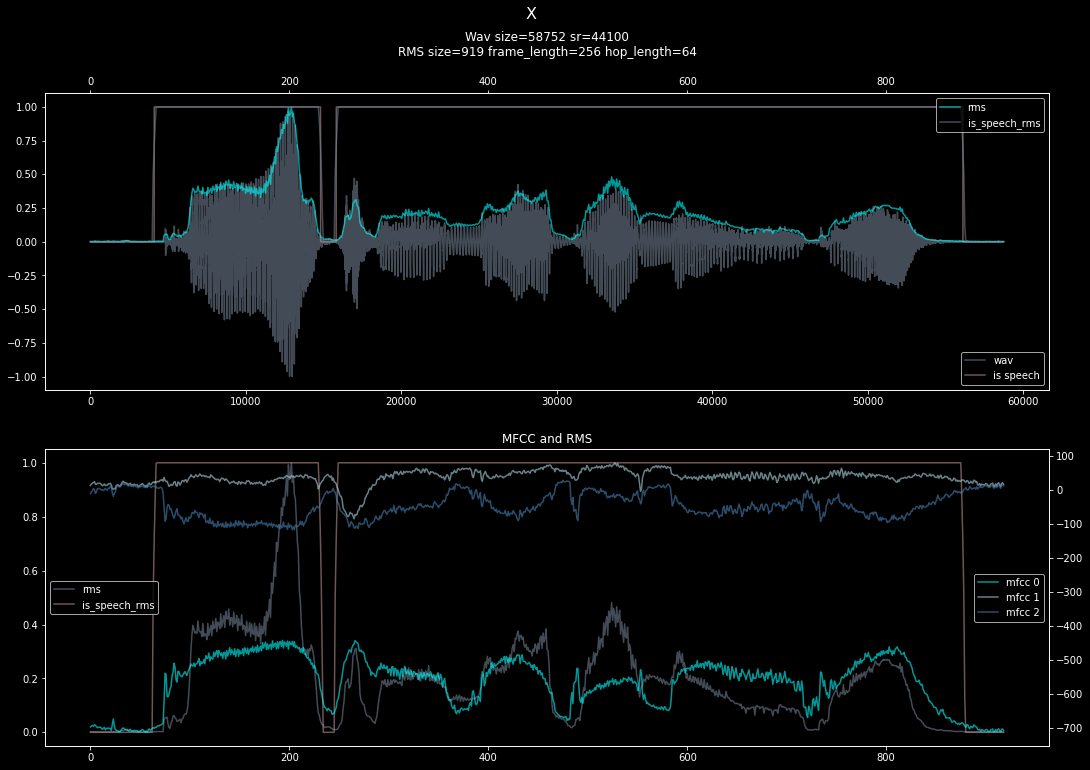

audio.py 

import math
import librosa
import numpy as np
from log import Log


class Audio:
    def __init__(self, path, sr=None, n_fft=256, n_hops=4, n_mfcc=8, pad_factor=16384):
        self.log = Log.set(self.__class__.__name__)
        self.n_fft = n_fft
        self.n_hops = n_hops
        self.hop_length = math.ceil(self.n_fft/self.n_hops)
        self.path = path
        wav_, sr_ = librosa.load(self.path, sr=sr)
        nice_size = math.ceil(len(wav_) / self.hop_length) * self.hop_length
        if nice_size != len(wav_):
            delta = nice_size - len(wav_)
            self.log.warning(f'Modifying input wav from size {len(wav_)} to {nice_size}')
            self.log.info(f'change in number of samples: {delta} [should be less than hop length: {self.hop_length}]')
            assert delta <= self.hop_length
        # wav_ = wav_[0:nice_size-1]
        wav_ = np.pad(wav_, (0,delta), 'constant')

        # if memory performance becomes a constraint we can skip setting the wav in the constructor
        # and move it into a method instead
        self.wav = librosa.util.normalize(wav_)
        self.mfcc = librosa.feature.mfcc(y=self.wav, sr=sr_, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=self.hop_length)
        self.rms = self.to_rms(self.wav)
        self.rms_frame_rate = self.n_fft
        self.sr = sr_
        self.size = len(self.wav)

    def to_idx(self, t):
        return math.ceil(self.sr * t)

    def to_rms(self, x):
        rms = librosa.feature.rms(y=x, frame_length=self.n_fft, hop_length=self.hop_length)
        self.log.info(f'a.to_rms size: {rms.shape[1]}, reduction factor {(len(x)/self.n_fft)*self.n_hops}')
        return librosa.util.normalize(rms, axis=1)

    # Return numpy array matching audio size
    # val_col here must point to a valid type (i.e., boolean)
    def val_from_interval(self, df, ivl_cols=None, val_col='value', missing_val=None):
        if ivl_cols is None:
            ivl_cols = ['start', 'stop']
        vals = np.full(self.size, missing_val)
        ivl_df = (df.loc[:, ivl_cols] * self.sr).apply(np.ceil).astype(int)
        ivl_df[val_col] = df.loc[:, val_col]
        for (start, stop, val) in ivl_df.values:
            vals[start:stop] = val
        return vals

    # TODO: Figure out a way to make this more flexible and not tightly coupled to 'syl' column
    def speech_from_interval(self, df, **kwargs):
        assert 'syl' in df.columns, 'Dataframe must have column named: \'syl\''
        df['value'] = np.where(df['syl'] == '0', False, True)
        return self.val_from_interval(df, **kwargs)

In [1]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from audio import Audio
from display import Disp
from kss_df import KssDf
disp = Disp(display)


# wav and TextGrid locations
data_dir = 'data/korean-single-speaker/kss/1'
kss_id = '1_0004'
kss_file_part = f'{data_dir}/{kss_id}'
audio_path_ = f'{kss_file_part}.wav'

# Create Audio object
a = Audio(audio_path_, n_fft=256, n_hops=4, n_mfcc=3)

# Create DF from TextGrid data
# syls_df = KssTextGrid(kss_id).syls_df()
syls_df = KssDf(kss_id).load_csv()
disp.obj(syls_df, f'Syllables for {kss_id}')
disp.obj(syls_df[syls_df['syl'] == '0'], f'Silence only rows for {kss_id}')

# Convert DF to values matching wav and rms size
is_speech_wav = a.speech_from_interval(syls_df, missing_val=False)
is_speech_rms = a.to_rms(is_speech_wav.astype(float)).flatten()

# plotting
fig, (ax1, ax2)  = plt.subplots(2, 1, figsize=(18,12))
fig.suptitle('X', fontsize=16)

ax1.set_title(f'Wav size={a.size} sr={a.sr}\nRMS size={len(a.rms.flatten())} frame_length={a.n_fft} hop_length={a.hop_length}\n')
ax1.plot(a.wav, color='slategray', alpha=0.6, label='wav')
ax1.plot(is_speech_wav, color='rosybrown', alpha=0.6, label='is speech')

ax1a = ax1.twiny()
ax1a.plot(a.rms.flatten(), color='cyan', alpha=0.6, label='rms')
ax1a.plot(is_speech_rms, color='slategray', alpha=0.6, label='is_speech_rms')
ax1.legend(loc='lower right')
ax1a.legend(loc='upper right')

ax2.set_title(f'MFCC and RMS')
ax2.plot(a.rms.flatten(), color='slategray', alpha=0.6, label='rms')
ax2.plot(is_speech_rms, color='rosybrown', alpha=0.6, label='is_speech_rms')
ax2.legend(loc='center left')

ax2a = ax2.twinx()
ax2a.plot(a.mfcc[0], color='cyan', alpha=0.6, label='mfcc 0')
ax2a.plot(a.mfcc[1], color='lightblue', alpha=0.6, label='mfcc 1')
ax2a.plot(a.mfcc[2], color='steelblue', alpha=0.6, label='mfcc 2')
ax2a.legend(loc='center right')

plt.show()

disp.audio(audio_path_, f'{audio_path_}')

# Audio source code
disp.code('audio.py', label='audio.py ')